# Coursework 1: Convolutional Neural Networks 
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Paperspace, where you can access GPUs.

You should receive an email at your imperial address inviting you to join the course team on PaperSpace (within a day of the coursework being released).

#### Paperspace
See [the Paperspace information doc](https://hackmd.io/@afspies/S1stL8Qnt). 

The public tests are embedded within the notebook. You can ignore the "tests" folder as it is only required for colab.


#### Google Colab
To run this notebook on Google Colab, please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

**To run the public tests within colab** you will need to copy the "tests" folder to the /content/ directory (this is the default working directory - you can also change directories with %cd). You may also need to place a copy of the CW ipynb in the /content/ directory. A better option is to mount colab on gdrive and keep the files there (so you only need to do the set up once).

#### Setup
You will need to install pytorch and other libraries by running the following cell:

In [58]:
%pip install scikit-learn
%pip install -q otter-grader pandoc torch torchvision sklearn seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [59]:
%pip install otter-grader

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Initialization Cell
import otter
grader = otter.Notebook("dl_cw_1.ipynb")
import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
import numpy as np
rng_seed = 90

## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations. 
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - w: Filter weights of shape (F, C, H', W',)
        - b: Biases of shape (F,)
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass
        ...
        # Do not initialize weights or biases with torch.empty() but rather use torch.zeros()


        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        
        # Bias should have shape [out_channels] 
        if bias == True:
            self.b = torch.zeros(out_channels)
        else: 
            self.b = None
        
        self.F = out_channels
        self.C = in_channels

        # initialise kernel size
        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size

        # initialise stride
        if isinstance(stride, int):
            self.stride = (stride, stride)
        else:
            self.stride = stride
        
        # initialise padding
        if isinstance(padding, int):
            self.padding = (padding, padding)
        else:
            self.padding = padding
        
        # initialise weights
        self.w = torch.zeros(self.F, self.C, self.kernel_size[0], self.kernel_size[1])

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass                                     #

        N, C, H, W = x.shape # N = batch size, C = number of channels, H = input height, W = input width
        x = x.to(torch.float32) # convert to float32 to avoid dtype errors
        # Calculate the output height and width
        H_out = int(((H + 2 * self.padding[0] - self.kernel_size[0]) / self.stride[0]) + 1)
        W_out = int(((W + 2 * self.padding[1] - self.kernel_size[1]) / self.stride[1]) + 1)

        # Initialise the output tensor
        out = torch.zeros(N, self.F, H_out, W_out)
        #x_pad = torch.zeros(N, C, H + 2 * self.padding[0], W + 2 * self.padding[1])
        #x_pad[:, :, self.padding[0]:self.padding[0] + H, self.padding[1]:self.padding[1] + W] = x
        
        # Convolution is can be reproduced by doing Unfold + Matrix Multiplication + Fold

        # Unfold the input tensor
        x_unfolded = F.unfold(x,self.kernel_size,stride=self.stride,padding=self.padding)

        # Matrix multiplication to calculate the output
        out_unfolded = x_unfolded.transpose(1,2).matmul(self.w.view(self.w.size(0),-1).t()).transpose(1,2)
        if self.b is not None: # if bias is inputed
            out_unfolded=out_unfolded+self.b.view(-1,1)

        # Fold the output tensor
        out=F.fold(out_unfolded,(int(H_out),int(W_out)),kernel_size=(1,1))
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out 

In [38]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # do i need to add stride here?
        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
            # in MaxPool2D documentation, the default value of stride of the window is kernel_size
            self.stride = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size
            # in MaxPool2D documentation, the default value of stride of the window is kernel_size
            self.stride = kernel_size
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
       

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape
        x = x.to(torch.float32) # convert to float32 to avoid dtype errors 
        
        H_out = int((H - self.kernel_size[0])//self.stride[0] + 1)
        W_out = int((W - self.kernel_size[1])//self.stride[1] + 1)
        out = torch.zeros(N, C, H_out, W_out)

        x_unfolded = F.unfold(x,kernel_size=self.kernel_size, stride = self.stride, padding=0)
        out_unfolded = x_unfolded.view(N,C,int(x_unfolded.shape[1]/C),-1).max(dim=2)[0]
        out = F.fold(out_unfolded, output_size=(H_out, W_out), kernel_size=1)

                        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [40]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

In [41]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason

        self.in_channels=in_channels
        self.out_channels=out_channels

        self.w = torch.zeros(in_channels, out_channels)

        if bias:
            self.b = torch.zeros(out_channels)
        else: 
            self.b = None
        ...
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        x = x.to(torch.float32) # convert to float32 to avoid dtype errors

        if self.b is not None:
            out = x @ self.w + self.b 
        else:
            out = x @ self.w
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [42]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

In [43]:
class BatchNorm2d(nn.Module):
	def __init__(self, num_features, eps=1e-05, momentum=0.1):
		super(BatchNorm2d, self).__init__()
		"""
		An implementation of a Batch Normalization over a mini-batch of 2D inputs.

		The mean and standard-deviation are calculated per-dimension over the
		mini-batches and gamma and beta are learnable parameter vectors of
		size num_features.

		Parameters:
		- num_features: C from an expected input of size (N, C, H, W).
		- eps: a value added to the denominator for numerical stability. Default: 1e-5
		- momentum: the value used for the running_mean and running_var
		computation. Default: 0.1 . (i.e. 1-momentum for running mean)
		- gamma: the learnable weights of shape (num_features).
		- beta: the learnable bias of the module of shape (num_features).
		"""
		# TODO: Define the parameters used in the forward pass                 #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		self.num_features = num_features
		self.eps = eps
		self.momentum = momentum

		# self.register_parameter is not used as it was mentioned on piazza
		# that this will be overridden
		
		
		self.gamma = torch.ones(num_features, requires_grad=True)
		self.beta = torch.zeros(num_features, requires_grad=True)
		
		# introduce parameters for running mean and variance
		self.running_mean = torch.zeros(1, num_features, 1, 1)
		self.running_var = torch.ones(1, num_features, 1, 1)

		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

	def forward(self, x):
		"""
		During training this layer keeps running estimates of its computed mean and
		variance, which are then used for normalization during evaluation.
		Input:
		- x: Input data of shape (N, C, H, W)
		Output:
		- out: Output data of shape (N, C, H, W) (same shape as input)
		"""
		# TODO: Implement the forward pass                                     #
		#       (be aware of the difference for training and testing)          #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		
		x = x.to(torch.float32) # convert to float32 to avoid dtype errors

		if self.training: # .training param is inhereted from nn.Module to indicate if we're in a training or eval mode
		
			mean = torch.mean(x, dim=(0, 2, 3), keepdim=True)
			var = torch.var(x, dim= (0, 2, 3), keepdim=True, unbiased=False)
			b_var = torch.var(x, dim= (0, 2, 3), keepdim=True, unbiased=True)
			
			x_hat = (x - mean) / torch.sqrt(var + self.eps)

			self.running_mean=self.running_mean * (1-self.momentum)+ mean*(self.momentum)
			self.running_var=self.running_var * (1-self.momentum) + b_var*(self.momentum)



			self.gamma = self.gamma.reshape(1, self.num_features, 1, 1)
			self.beta = self.beta.reshape(1, self.num_features, 1, 1)
			
			
			out = self.gamma * x_hat + self.beta

		else: 

			self.gamma = self.gamma.reshape(1, self.num_features, 1, 1)
			self.beta = self.beta.reshape(1, self.num_features, 1, 1)

			x_hat = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)
			out = self.gamma * x_hat + self.beta
		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		
			
		return out

In [44]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (30 points)
    * 10 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (10 points)

**Downloading NaturalImageNet**

In [1]:
ON_COLAB = False

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else: 
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

!yes | rm NaturalImageNetTest.zip?download=1

--2023-02-05 21:37:44--  https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138507970 (132M) [application/octet-stream]
Saving to: ‘NaturalImageNetTest.zip?download=1.2’

NaturalImageNetTest 100%[===================>] 132.09M  35.1MB/s    in 4.4s    

2023-02-05 21:37:50 (30.1 MB/s) - ‘NaturalImageNetTest.zip?download=1.2’ saved [138507970/138507970]

--2023-02-05 21:37:51--  https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1383630100 (1.3G) [application/octet-stream]
Saving to: ‘NaturalImageNetTrain.zip?download=1.3’

NaturalImageNetTrai 100%[===================>]   1.29G  24.6MB/s  

^C
replace NaturalImageNetTrain/gorilla/183671517_a2638083e4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [36]:
#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [73]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

ON_COLAB = False
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

# create a transform to normalise the data

transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )

# create transforms to augment the data

transform_tr1 = transforms.Compose(  # to accont for different lightining conditions
        [
            transforms.Resize(256), 
            transforms.CenterCrop(256),
            transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.5, 1), saturation=(0.5, 1), hue=(-0.2, 0.2)),
            transforms.RandomAdjustSharpness(sharpness_factor=2),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )

transform_tr2 = transforms.Compose( # to account for different points of view (different perspectives and rotation angles)
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.RandomPerspective(distortion_scale=0.7, p=1.0),
            transforms.RandomRotation(degrees=(0, 360), expand=False, center=None, fill=None),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ]
    )

transform_tr3 = transforms.Compose( # to account for blur from motion or low resolution and object occlusion
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.RandomResizedCrop(256,scale=(0.2,0.75)),
            transforms.GaussianBlur(kernel_size=5, sigma=(0.2, 2.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ]
    )

# Load the data to train and test the model

train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'

train_dataset1 = datasets.ImageFolder(train_path, transform=transform)
train_dataset2 = datasets.ImageFolder(train_path, transform=transform_tr1)
train_dataset3 = datasets.ImageFolder(train_path, transform=transform_tr2)
train_dataset4 = datasets.ImageFolder(train_path, transform=transform_tr3)

test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Create train val split
n = len(train_dataset1)
n_val = int(n/10)

train_set1,val_set = torch.utils.data.random_split(train_dataset1, [n-n_val, n_val],generator=torch.Generator().manual_seed(rng_seed))
train_set2,val_set2 = torch.utils.data.random_split(train_dataset2, [n-n_val, n_val],generator=torch.Generator().manual_seed(rng_seed))
train_set3,val_set3 = torch.utils.data.random_split(train_dataset3, [n-n_val, n_val],generator=torch.Generator().manual_seed(rng_seed))
train_set4,val_set4 = torch.utils.data.random_split(train_dataset4, [n-n_val, n_val],generator=torch.Generator().manual_seed(rng_seed))

train_set = torch.utils.data.ConcatDataset([train_set1,train_set2,train_set3,train_set4])
#train_set = train_set1

print(len(train_set), len(val_set), len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number! 
batch_size = 32

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

71944 1998 2000


In [74]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images** 

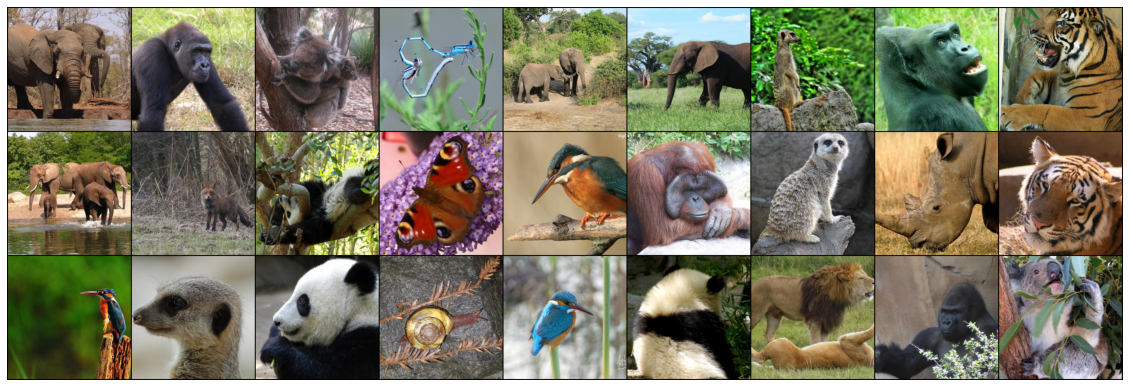

In [95]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [76]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 20):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        #self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        #self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride = 2)

        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.avgpool=nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #x = self.layer5(x)
        #x = self.layer6(x)
        #x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# please do not change the name of this class
def MyResNet():
    return ResNet(ResidualBlock)

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None, 
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [84]:
USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)
    

print_every = 10
def check_accuracy(loader, model, analysis=False, metrics = True):
    # function for test accuracy on validation and test set
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode

  
    #### Added code for additional performance metrics #####
    if metrics:
        preds_buffer = torch.tensor([], device=device)
        targets_buffer = torch.tensor([], device=device)
    ########################################################



    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            #### Added code for additional performance metrics #####
            if metrics:
                preds_buffer = torch.cat((preds_buffer, preds),dim=0) 
                targets_buffer  = torch.cat((targets_buffer, y),dim=0) 
            ########################################################

            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        
        #### Added code for additional performance metrics #####
        if metrics: 
            return float(acc), preds_buffer, targets_buffer
        else: 
        ########################################################
            return float(acc)
        
        

def train_part(model, optimizer, epochs=1, ifcurve=False, verbose = True, finalacc = False):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    ####### Added code for plotting learning curves ########
    if ifcurve:
        accuracy_history= []
        loss_history = []
    ########################################################
    

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print('Epoch %d' % e)
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                
                ####### Added code for plotting learning curves ########
                if ifcurve:
                    accuracy = check_accuracy(loader_val, model)
                    accuracy_history.append(accuracy)
                    loss_history.append(loss.item())
                
                #######################################################
                if verbose:
                    print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
            
        acc = check_accuracy(loader_val, model)
        
    ####### Added code for plotting learning curves ########
    if ifcurve:
        return accuracy_history, loss_history
    if finalacc:
        return acc
    ########################################################
              

cuda:0


In [85]:

# hyperparameter search space
batch_size_range = [16, 32, 64]
lr_range = [1e-5, 1e-4, 1e-3,]
weight_decay_range = [1e-7, 1e-5, 1e-3]

grid_search_results = {}

for batch_size in batch_size_range: 
    loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
    #loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    for lr in lr_range: 
        for weight_decay in weight_decay_range:  
            model = MyResNet()
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
            acc = train_part(model, optimizer, epochs=10, verbose = False, finalacc = True)
            print('batch_size: ', batch_size, 'lr: ', lr, 'weight_decay: ', weight_decay)
            print(f'Final accuracy on validation set: {acc}')
            grid_search_results.setdefault((batch_size, lr, weight_decay), acc)




Epoch 0
Got 936 / 1998 correct of val set (46.85)
Epoch 1
Got 1110 / 1998 correct of val set (55.56)
Epoch 2
Got 1216 / 1998 correct of val set (60.86)
Epoch 3
Got 1300 / 1998 correct of val set (65.07)
Epoch 4
Got 1342 / 1998 correct of val set (67.17)
Epoch 5
Got 1388 / 1998 correct of val set (69.47)
Epoch 6
Got 1428 / 1998 correct of val set (71.47)
Epoch 7
Got 1424 / 1998 correct of val set (71.27)
Epoch 8
Got 1490 / 1998 correct of val set (74.57)
Epoch 9
Got 1484 / 1998 correct of val set (74.27)
batch_size:  16 lr:  1e-05 weight_decay:  1e-07
Final accuracy on validation set: 0.7427427427427428
Epoch 0
Got 946 / 1998 correct of val set (47.35)
Epoch 1
Got 1118 / 1998 correct of val set (55.96)
Epoch 2
Got 1258 / 1998 correct of val set (62.96)
Epoch 3
Got 1312 / 1998 correct of val set (65.67)
Epoch 4
Got 1341 / 1998 correct of val set (67.12)
Epoch 5
Got 1367 / 1998 correct of val set (68.42)
Epoch 6
Got 1417 / 1998 correct of val set (70.92)
Epoch 7
Got 1437 / 1998 correct of

In [86]:
sorted_models = sorted(grid_search_results.items(), key = lambda x: x[1], reverse=True)

In [87]:
sorted_models

[((32, 0.001, 1e-07), 0.8643643643643644),
 ((32, 0.001, 0.001), 0.8598598598598599),
 ((16, 0.001, 1e-05), 0.8583583583583584),
 ((16, 0.001, 1e-07), 0.8563563563563563),
 ((16, 0.0001, 1e-05), 0.8553553553553553),
 ((64, 0.001, 0.001), 0.8523523523523524),
 ((16, 0.001, 0.001), 0.8493493493493494),
 ((16, 0.0001, 0.001), 0.8483483483483484),
 ((32, 0.0001, 1e-07), 0.8423423423423423),
 ((32, 0.001, 1e-05), 0.8423423423423423),
 ((16, 0.0001, 1e-07), 0.8393393393393394),
 ((32, 0.0001, 1e-05), 0.8383383383383384),
 ((64, 0.001, 1e-05), 0.8373373373373373),
 ((64, 0.001, 1e-07), 0.8368368368368369),
 ((32, 0.0001, 0.001), 0.8288288288288288),
 ((64, 0.0001, 0.001), 0.8158158158158159),
 ((64, 0.0001, 1e-05), 0.8063063063063063),
 ((64, 0.0001, 1e-07), 0.8038038038038038),
 ((16, 1e-05, 1e-07), 0.7427427427427428),
 ((16, 1e-05, 0.001), 0.7332332332332332),
 ((16, 1e-05, 1e-05), 0.7327327327327328),
 ((32, 1e-05, 0.001), 0.7152152152152152),
 ((32, 1e-05, 1e-07), 0.7127127127127127),
 (

In [96]:
best_batch_size, best_lr, best_weight_decay = sorted_models[0][0]
print(f'Best batch size: {best_batch_size}, best learning rate: {best_lr}, best weight decay: {best_weight_decay}, performance: {sorted_models[0][1]}')

Best batch size: 32, best learning rate: 0.001, best weight decay: 1e-07, performance: 0.8643643643643644


Total number of parameters is: 11183316
Epoch 0
Got 141 / 1998 correct of val set (7.06)
Got 149 / 1998 correct of val set (7.46)
Got 207 / 1998 correct of val set (10.36)
Got 227 / 1998 correct of val set (11.36)
Got 265 / 1998 correct of val set (13.26)
Got 249 / 1998 correct of val set (12.46)
Got 373 / 1998 correct of val set (18.67)
Got 325 / 1998 correct of val set (16.27)
Got 380 / 1998 correct of val set (19.02)
Got 338 / 1998 correct of val set (16.92)
Got 301 / 1998 correct of val set (15.07)
Got 431 / 1998 correct of val set (21.57)
Got 457 / 1998 correct of val set (22.87)
Got 384 / 1998 correct of val set (19.22)
Got 330 / 1998 correct of val set (16.52)
Got 439 / 1998 correct of val set (21.97)
Got 413 / 1998 correct of val set (20.67)
Got 483 / 1998 correct of val set (24.17)
Got 466 / 1998 correct of val set (23.32)
Got 421 / 1998 correct of val set (21.07)
Got 402 / 1998 correct of val set (20.12)
Got 499 / 1998 correct of val set (24.97)
Got 419 / 1998 correct of val 

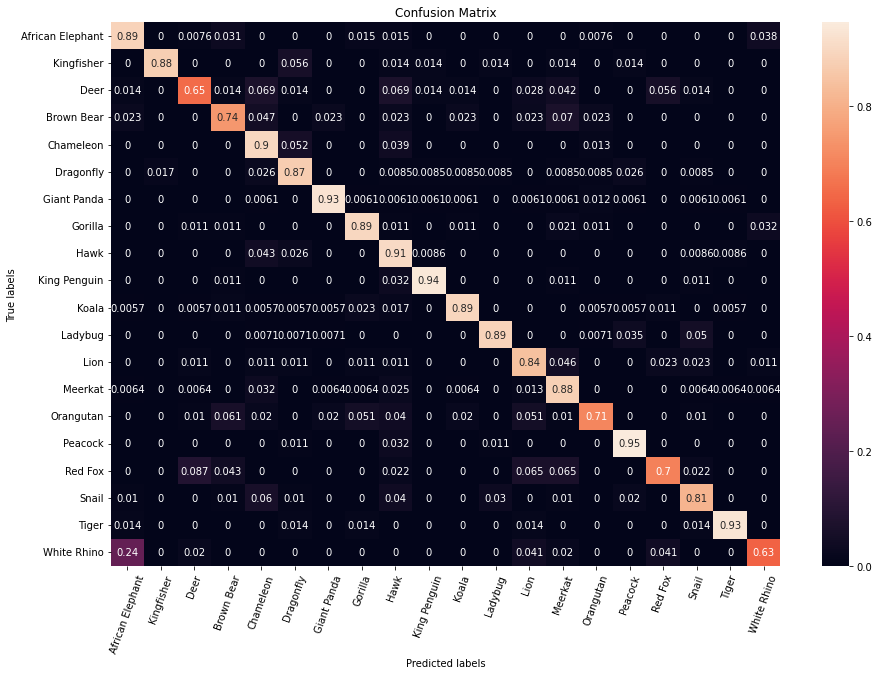

Predicted label ['White Rhino']
True label ['African Elephant']
Corresponding images are shown below


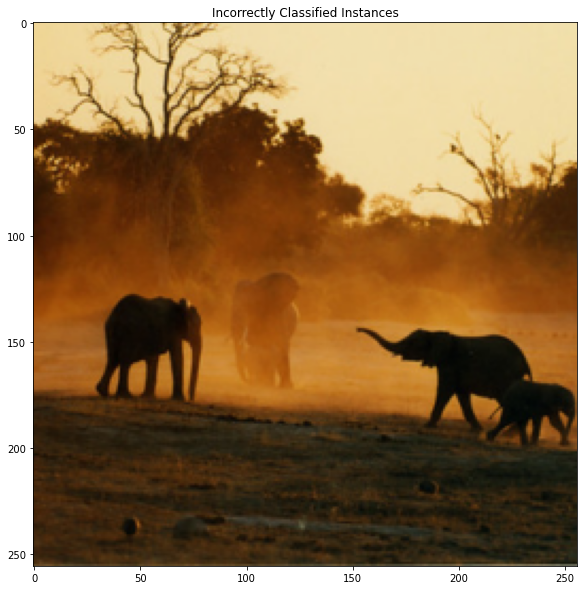

In [88]:
# define and train the network

# optimal parameters
model = MyResNet()
batch_size = 32
lr = 0.001
weight_decay = 1e-7
epochs = 10

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

#optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=weights_decay) - original 

# new optimizer 
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

acc_hist, loss_hist = train_part(model, optimizer, epochs = 10, ifcurve = True, verbose = True, finalacc = False)

# report validation set accuracy
check_accuracy(loader_val, model, analysis=True, metrics = False)

# save the model
torch.save(model.state_dict(), 'model.pt')

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 1674 / 2000 correct of val set (83.70)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


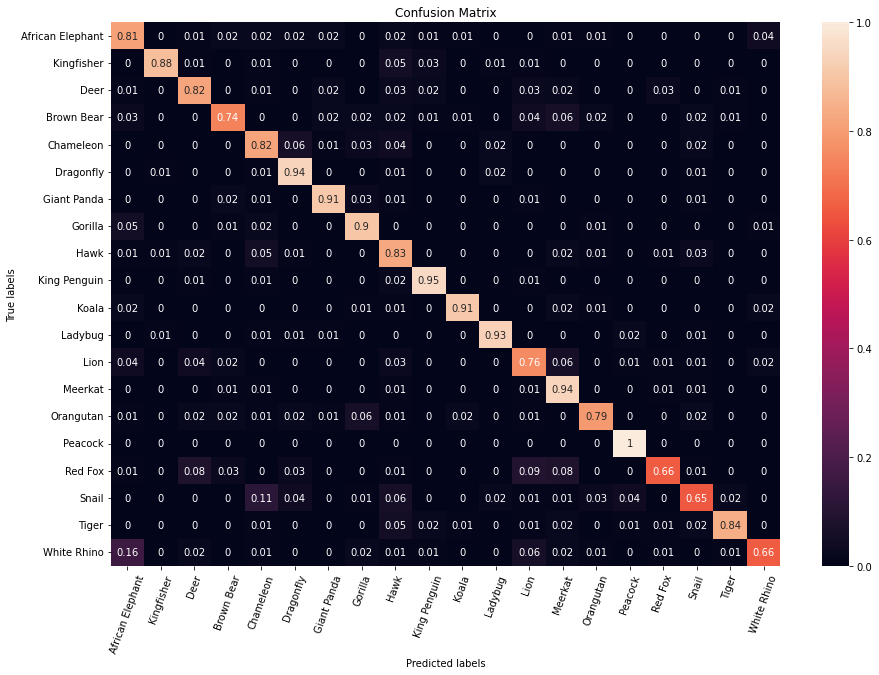

Predicted label ['Giant Panda']
True label ['African Elephant']
Corresponding images are shown below
Got 1674 / 2000 correct of val set (83.70)


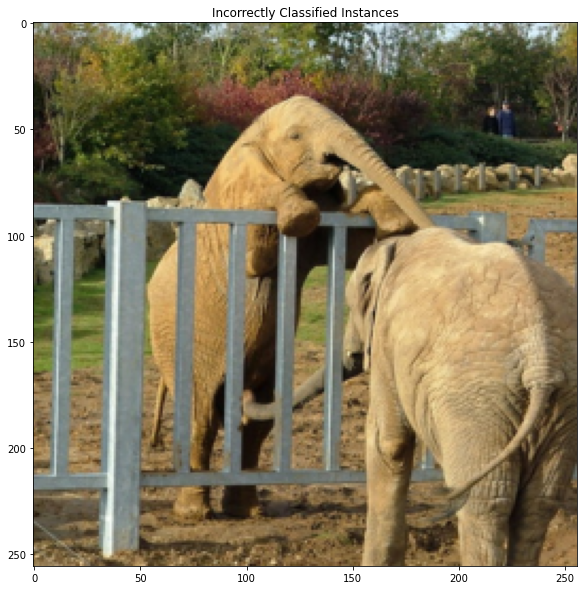

In [90]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True, metrics=True)
acc_test, predictions, targets = check_accuracy(loader_test, model, metrics=True)

In [91]:
#Analzying Precision, Recall, F1 score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support 
prec, recall, f1score,_ = precision_recall_fscore_support(targets.cpu(), predictions.cpu())

print('Precision: %.2f' %np.mean(prec*100))
print('Recall: %.2f' %np.mean(recall*100))
print('F1: %.2f' %np.mean(f1score*100))

Precision: 84.40
Recall: 83.70
F1: 83.63


___

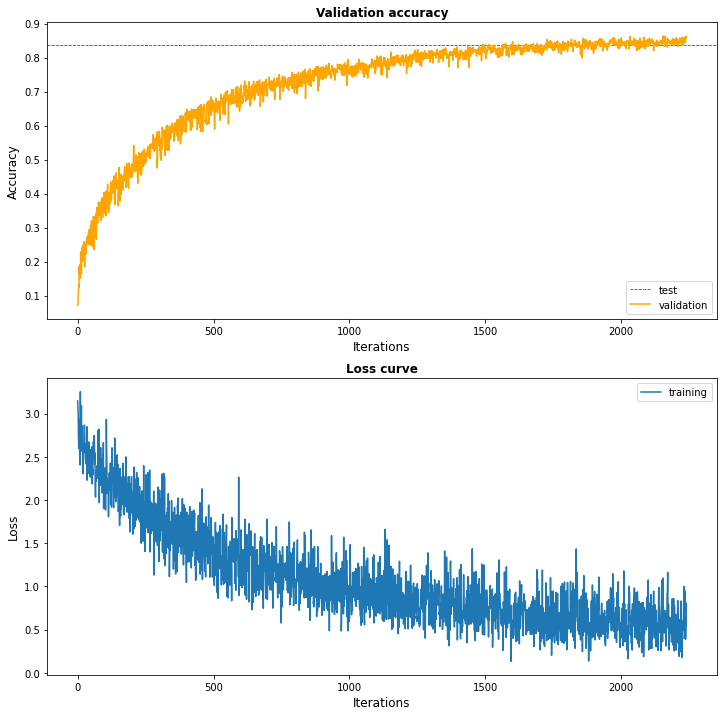

In [93]:
# Visualizations
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(12)
fig.set_figwidth(12)

# Add a baseline showing the test accuracy
ax1.axhline(y=acc_test, color='r', linestyle='--', linewidth=0.8, label="test")

# Plot Accuracy
iters = np.linspace(0, 2250 - print_every, int(22500/print_every))
ax1.plot(iters, acc_hist, label="validation", color = 'orange')
ax1.set_title('Validation accuracy', fontsize='large', fontweight='bold')
ax1.set_xlabel('Iterations', fontsize='large')
ax1.set_ylabel('Accuracy', fontsize='large')   
ax1.legend()

# Plot Loss
ax2.plot(iters, loss_hist, label="training")
ax2.set_title('Loss curve', fontsize='large', fontweight='bold')
ax2.set_xlabel('Iterations', fontsize='large')
ax2.set_ylabel('Loss', fontsize='large')    
ax2.legend()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**
There exists several methods for performing a hyperparameter search: 

1) **Trial and Error**: the most basic method which consitutes manually trying different values for hyperparameters (in sequential order) to determine which combination of hyperparameters gives better performance. Such method is very time consuming even for a small number of hyperparameters, lacks systematic approach and might lead to missing out on potentail optimal hyperparameters combinations. Therefore, it is not recommended for large networks.

2) **Grid search**: represents a systematic brute force method where all possible combinations of hyperparameters are explored within the defined discrete value ranges for each hyperparameter involved in search. As such, Grid Search defines a search space as a grid of hyperparameter values, and systematically evaluates every position in this grid.nThis method is very time consuming and computationally expensive, and is therefore not be feasible for large networks as it lacks the capacity to search over all of the possible hyperparameter combinations in the search space. Nevertheless, it is a usefull tool for problems with a small number of hyperparameters, or where the network performance is already quite high and the direction of improvement is known (e.g. increasing the learning rate, or decreasing the weight decay etc). Grid search is therefore commonly used to spot-check hyperparameter combinations that known to perform well generally. 

3) **Random search**: is a method that randomly samples a continious hyperparameter search space, which is defined as bounded domain of hyperparameter values. This method is great for discovery, and identifying efficient hyperparameter combinations that you would not have gotten intuitively, and, therefore, represents a more efficient alternative to grid search. However, it is still computationally expensive and requires more time to execute in comparisson to grid search. Similarly to grid search, it will not be able to explore the entire search space.

4) **Bayesian optimization** is a more advanced method that uses a probabilistic model to optimize hyperparameters. It is based on the idea of building a probability model to approximate the objective function, and then using it to find the most promising hyperparameter combinations to yield best results when evaluating this combination using the true objective function. This method is more efficient than grid search and random search as it allows to choose next hyperparameter combination for evaluation **based on previous results**, while grid search and random search are completely uninformed by past evaluations. However, this method is computationally expensive, and is not available in classic ML packages such as scikit-learn.

5) **Evolutionary algorithms** are a class of algorithms that use evolutionary principles to solve optimization problems. They are based on the idea of mimicking the process of natural evolution, each set of hyperparameters is represented as an infividual, and the fittest individuals (hyperparameter combinations that yield the highest scores) are selected for reproduction in order to produce offspring (new sets of hyperpameters, that is based on previously successul set of hyperparameters, a.k.a. parents). This method is very efficient and can be used to explore the entire search space. 


Given the long training time of the network for one set of hyperparameters (over an hour), limited GPU resources and the time constraints of the coursework, I was planning to use a combination of Trial and Error Approaches, small Grid Search and small Random Search to find an optimal set of hyperameters. However, as Trial and Error in conjunction with Data Augmentation and improvements to the ResNet Architecture have yielded considerable impovements in the networks performance straigtaway (from 35% baseline performance to 80% performance) and given the limited GPU resources (problems), I have decided to limit my hyperparameter tuning to Trial and Error Approach in combination with a small Grid Search (over 27 models) to further finetune the network performance. 

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions 

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

The baseline validation accuracy of the model was 35% on validation set. The following engineering decisions were made to boost the performance of the baseline results:

#### 1) Data augmentation. 
CNNs are only approximately transformation equivariant through convolution and only approximately transformation invariant trhough pooling and stride. However, the model's equivariance and invariance to various transformations, and therefore the model's performece, can be improved by data augmentation. Thus, I decided to perform data augmentation as a first step: it improves the network training process by generating new modified training data instances (transforms of the existing training data). This method is very effective as it allows to increase the size of the training dataset and improving the generalisation of the model without having to collect more data. This was achieved by applying minor geometric transformations to the existing images in the dataset (randomly rotating, cropping, flipping and applying random colour distortions to the images), which helped to increase the diversity of the training dataset and improve its robustness against to changes in the input images (i.e. when anumal was not the main focus of the image, when the animal was not facing the camera or partially obstructed, when the animal was moving and therefore blurred etc). This method has helped to improve the performance of the model by approvimately 34% on the validation set (from 35% to 69%). I have created 3 additional augmented datasets to complement the original dataset, and have used them to train the model. They included:
1. First augmented dataset aimed to improve the model generalisation capacity by 
    1) simulating changes in illumination conditions by applying ColorJitter and RandomAdjustSharpness transforms 
    2) enriching the dataset with additional images of the same animal but flipped (increasing variety) by applying RandomHorizontalFlip and RandomVerticalFlip transform
2. Second augmented dataset aimed to improve the model generalisation capacity by: 
    1) simulating changes in the camera angle/position in relation to the animal by applying RandomRotation and RandomPerspective transforms
    2) improving robustness to obstruction of the animal by applying RandomResizedCrop transform
    3) enriching the dataset with additional images of the same animal but flipped (increasing variety) by applying RandomHorizontalFlip and RandomVerticalFlip transform
3. Third augmented dataset aimed to improve the model generalisation capacity by:
    1) simulating blur effect from motion and low resolution conditions through application of GaussianBlur transform 
    3) enriching the dataset with additional images of the same animal but flipped (increasing variety) by applying RandomHorizontalFlip and RandomVerticalFlip transform

#### 2) Improvements to the ResNet Architecture
I have changed the number of output channels of the convolutional layer (first layer) in my ResNet from 16 to 64 channels. The output channels of the convolutional layers represent the basic features of the image captured by the network during training. As the depth of the network increases, the number of output channels of the subsequent layers also increases. This is because the deeper layers of the network are responsible for capturing more complex (finer) features. Increasing the number of output channels of the first convolutional layer allowed to capture more basic features, and therefore learn finer (more complex/class-specific) features in the deeper layers of the ResNet. It turned out to be a useful modification of the model given the vast diversity of basic features across different classes of the animals: it has helped to improve the performance of the model by approximately 5% on the validation set (from 69% to 74%).

#### 3) Changing the Optimizer. 
I have changed the initially suggested optimizer to AdamW as it allowed to further improve the performance of the model by approximately 6% on the validation set (from 74% to 80%). While Adam optimisation algorithm is generally an optimiser of choice for deep learning moderl (Kingma and Ba, 2014), AdamW is a variant of Adam optimizer that decouples weigth decay from the gradient update by altering the way that L2 regularisation is performed (Loshchilov and Hutter, 2019). This method is very effective as it helps to generalisation performance of Adam, and has been shown to be particularly successful in image classification tasks as shown in paper by Loshchilov and Hutter, 2019: Decoupled Weight Decay Regularization. 

#### 4) Trial and Error and Grid Search of Hyperparameters:
I have performed the hyperparameter search of the following hyperparameters:
    
1) Batch size (initally 128)
2) Learning rate (initially 0.0001)
3) Weight decay (initially 1e-7)
4) Number of epochs (initially 10)

As a result, the following hyperparameters were found to be optimal: 
1) Batch size = 32
2) Learning rate = 0.001
3) Weight decay = 1e-07
4) Number of epochs = 10. 


These hyperparameters have helped to improve the performance of the model by approximately 6 % on the validation set (from 80% to 85-87% as the performance differs across different runs of the model).
    
Due to long training time of the model (330 mins per 10 epochs), I have decided to resort to initial num_epochs = 10, given the time constraints of the coursework and lack of significant and stable improvement introudced by increasing the number of epochs.

By decreasing the batch size, we increased the number of updates that the model receives in each iteration, and increased the amount of variance (noise) in the data that the model 'absorbs' with each iteration as there's more variance across calculated gradients for each batch. Introducing more noise allows to increase the generalisation abilities of the model by preventing it from overfitting to the training data.

Increasing the learning rate and weight decay allowed to speed up the pace at which the model learns, and therefore to improve the performance of the model.
    


---

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(: 

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

As we move from low-level layers to high-level layers, the feature maps become more class-specific and more abstract.

1) The feature maps from superficial layers (e.g. layer 1) capture the basic features of the image (e.g. edges, diretions, contours, corners, etc.) and are less class-specific. In the example below, superficial layers seem to extract edges, contours, as well as large uniform regions of high/low intensity in the image of the animal.
2) The feature maps from mid-depth layers (e.g. layer 2-3) capture progressively more complex and class-specific features of the image (e.g. shapes, textures, etc.) and are more class-specific. In the example below, mid-depth layers seem to extract shapes, textures, as well as smaller uniform regions of high/low intensity in the image of the animal.
3) The feature maps from deep layers (e.g. layer 4) capture fine details such as unique parts of object from a particual class.In the example provided below, it seems like it could represent the  anatomy of the animal (e.g. where the wing, legs, head or beak could be located). However,at such high level of abstraction, it very difficult to interpret the feature maps from deep layers. 

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

Given the validation accuracy of 85-87% and test accuracy of 84%, I think that the performance of the model is mostly good, but could use further improvement. While the model in general can quite classify 16/20 classes of animals using the test set (the normalised TP rate varies from 0.75 to 1.00), it's performance in classifying the 4 classes of animals in the test set (White Rhino, Red Fox, Snail and Brown Bear) is not as good (from 0.66 to 0.74). This might be explained by inherent problems of the images provided for these classes (e.g., upon inspection of the images for White Rhino and Red Fox, the animal was found to be occluded and cropped in a large proportion of dataset images, or humans were present in the picture with the animal). Moreover, White Rhino commonly is mistaken for a white elephant by the model, red fox is commonly misclassified as a deer, lion or meerkat,  while snail is commonly misclassified as a chameleon. The high rate of such missclassifications can be explained by the similarities in the animal's visual appearences (i.e. colors and textures of the skin, fur, etc.). Interestingly, most of the inaccuretely recognised classes (White Rhino, Red Fox, Snail) have a high proportion of False Negatives in the Confusion Matrix. Therefore, it could be suggested that intorducing more data for these classes could help to improve the performance of the model by learning more complex features of the images of these classes.

However, given the baseline performance of 35% on validation test, the resulting performance of the model shows significant improvement. Moreover, the feature map demosnstrated that the model succedded in learning the basic features of the images in the superficial layers and more complex features of the images in the mid-depth layers.

Nevertherless I think that the performance of the model could be further improved by:

1) Employing random search, Bayesian optimisation or Evolutionary algorithms to perform the hyperparameter search. This would allow to find the most optimal hyperparameters for the model, and therefore improve the performance of the model.
2) Increasing the search space for hyperparameter optimisation by either increasing the number of hyperparameters to be optimised, or by increasing the range of values for each hyperparameter. Additional hyperparameters that could be optimised include:
    1) Number of layers and number of channels in each layer of the ResNet
    2) Experimenting with different types of filters within each layer of the ResNet 
    3) Experimenting with more complex architectures of the ResNet (e.g. ResNet-50, ResNet-101, etc.)
    4) Experimentign with different types of optimizers (e.g. RMSProp, Nadam, FTRL, etc.)
    5) Early in the training, the learning rate should be larger in order to rapidly learn the set of weights that are good enough. However, large learnhing rate steps can lead to 'overshooting' which causes to miss the optima in the loss functions. Therefore, decreasing the learning weight over time can allow to fine-tune the good-enough weights and reach to reach higher accuracy by doing smaller steps. This can be achieved by introducing learning rate decay or learning rate schedulers (e.g ReduceLROnPlateau, CosineAnnealingLR, etc).
    6) Experimenting with different activation functions (e.g. LeakyReLU, ELU, etc., SELU, GELU, CELY, etc.)
    7) Experimenting with different loss functions (e.g. Focal Loss,Huber, Poisson, etc.)

3) Further experimenting with different types of data augmentation to account for presence of multiple objects in the image (i.e. humans wiht animals, animals with other animals, several anumals)) and ntroduce more data for the classes that are commonly misclassified by the model (e.g. White Rhino, Red Fox, Snail)

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

The other possible ways to analyse the performance of the model include:
1) Computing the precision, recall and F1-score for each class of animals. I have implemented that and it produced the following resutls for the test set: 
    1) Precision: 84.40
    2) Recall: 83.70
    3) F1: 83.63

2) Using learning curves for loss and accuracy across iterations to how the model is learning, which I have also implemented in the cells above. 
    
Other possible ways to analyse the performance of the model, which I have not implemented include:
1) Computing the ROC curve and AUC score for each class of animals
2) Computing the precision-recall curve for each class of animals
3) Computign a weighted F1 score 

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture). 

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [37]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))
        

    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2
        
        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 432x288 with 0 Axes>

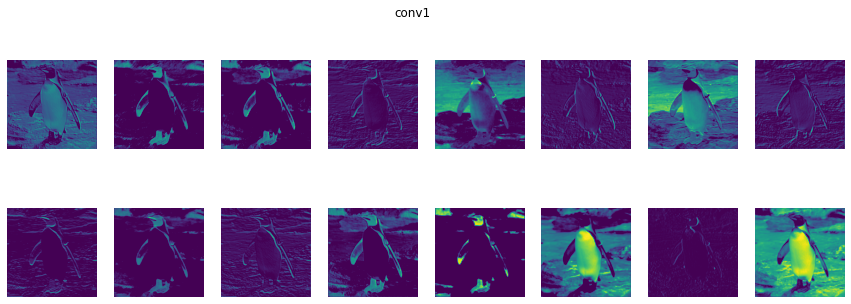

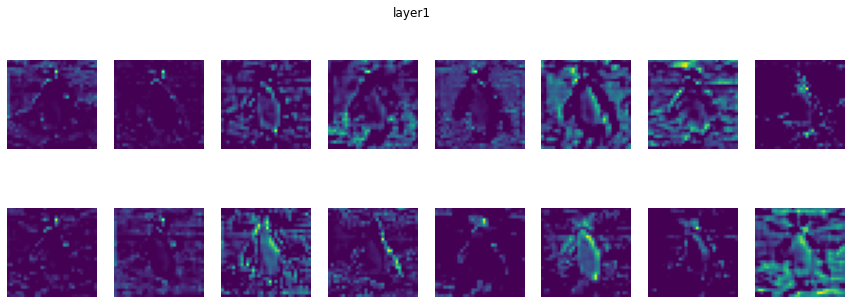

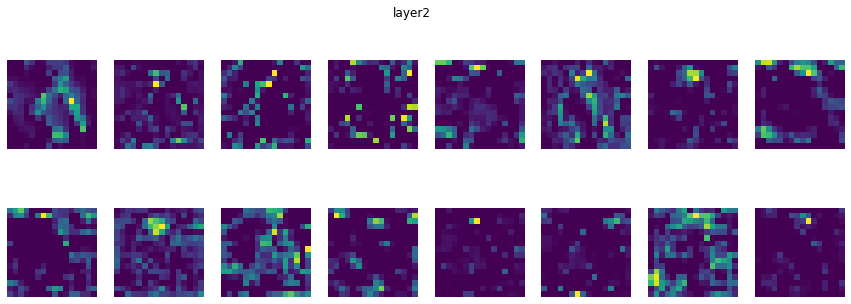

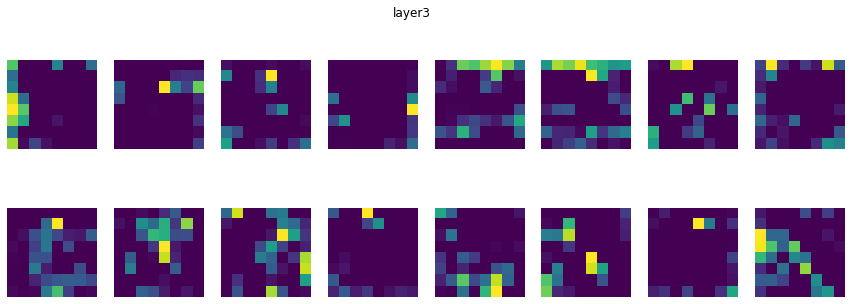

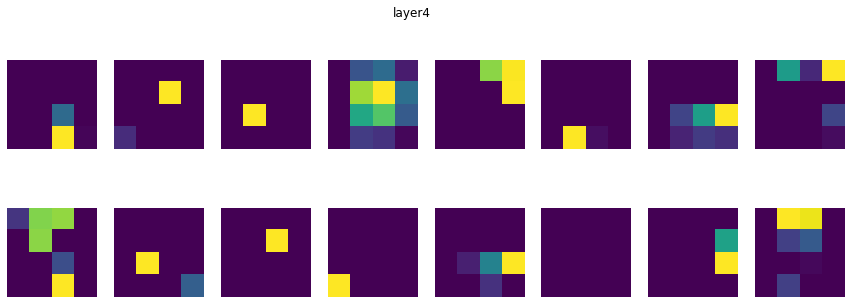

In [94]:
# Visualize the figure here, so it is exported nicely
plot_model_features()  

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [45]:
grader.check_all()

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed